# WLASL100 Dataset - CTR-GCN Model Pipeline

The CTR-GCN model is a state-of-the-art model that is specifically designed for skeleton-based action recognition. It models relationships between body joints and hand landmarks as a graph and captures temporal dynamics across frames, but dynamically learns graph structure instead of using a fixed one.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [20]:
!pip install sympy==1.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


## Google Drive Setup

In [2]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/wlasl100_features.zip'
extract_path = '/content/wlasl100_features'

if not os.path.exists(extract_path):
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Unzipping Done!")
else:
    print("Dataset already unzipped.")

dataset_root = '/content/wlasl100_features'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already unzipped.


## Data

In [3]:
class WLASL100Dataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.split_dir = os.path.join(root_dir, split)
        self.files = []

        for root, _, filenames in os.walk(self.split_dir):
            for filename in filenames:
                if filename.endswith('.npy'):
                    self.files.append(os.path.join(root, filename))

        if len(self.files) == 0:
            print(f"Warning: No files found in {self.split_dir}.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]

        # load dictionary
        data_dict = np.load(path, allow_pickle=True).item()
        raw_data = data_dict['data']

        # reshape: (time, points, channels) -> (32, 75, 3)
        reshaped_data = raw_data.reshape(32, 75, 3)
        features = torch.tensor(reshaped_data, dtype=torch.float32)

        # permute for ST-GCN: (channels, time, points) -> (3, 32, 75)
        features = features.permute(2, 0, 1)

        # extract label
        label = torch.tensor(data_dict['label'], dtype=torch.long)

        return features, label

In [4]:
# getting label map from preprocessing
label_map_path = "/content/wlasl100_features/label_map.json"
if os.path.exists(label_map_path):
    with open(label_map_path, 'r') as f:
        label_map = json.load(f)
    NUM_CLASSES = len(label_map)
    print(f"Found {NUM_CLASSES} classes in label_map.")
else:
    raise FileNotFoundError("Error: wlasl100_label_map.json not found")

Found 100 classes in label_map.


## Graph Creation

In [5]:
class Graph:
    def __init__(self, strategy='spatial'):
        self.num_node = 75  # 33 Pose + 21 LH + 21 RH
        self.edges = self.get_edges()

        # get center node for spatial configuration
        # MediaPipe: 0 = nose
        self.center = 0

        if strategy == 'spatial':
            self.A = self.get_spatial_graph()
        else:
            self.A = self.get_uniform_graph()

    def get_edges(self):
        self_link = [(i, i) for i in range(self.num_node)]

        # pose connections (0-32)
        pose_connect = [
            (0,1), (1,2), (2,3), (3,7), (0,4), (4,5), (5,6), (6,8), # face
            (9,10), (11,12), (11,13), (13,15), (12,14), (14,16),    # arms
            (11,23), (12,24), (23,24), (23,25), (24,26), (25,27), (26,28), # torso/legs
            (27,29), (29,31), (28,30), (30,32) # feet
        ]

        # hand connections
        # LH starts at 33, RH starts at 54
        def get_hand_edges(offset):
            edges = []
            # wrist (0) to fingers (1, 5, 9, 13, 17)
            for i in [1, 5, 9, 13, 17]:
                edges.append((0+offset, i+offset))
            # finger segments
            for i in [1, 5, 9, 13, 17]:
                edges.append((i+offset, i+1+offset))
                edges.append((i+1+offset, i+2+offset))
                edges.append((i+2+offset, i+3+offset))
            return edges

        lh_connect = get_hand_edges(33)
        rh_connect = get_hand_edges(54)

        # connecting hands to body) ---
        # pose left wrist (15) <-> LH wrist (0+33 = 33)
        # pose right wrist (16) <-> RH wrist (0+54 = 54)
        inter_connect = [(15, 33), (16, 54)]

        # combine all edges
        return self_link + pose_connect + lh_connect + rh_connect + inter_connect

    def get_uniform_graph(self):
        A = np.zeros((self.num_node, self.num_node))
        for i, j in self.edges:
            A[j, i] = 1
            A[i, j] = 1
        return self.normalize_digraph(A)

    def get_spatial_graph(self):
        # calculate hop distances from center
        link_mat = np.zeros((self.num_node, self.num_node))
        for i, j in self.edges:
            link_mat[i, j] = 1
            link_mat[j, i] = 1

        # bfs to find distance of every node from root
        max_dist = 100
        dists = np.zeros(self.num_node) + max_dist
        dists[self.center] = 0
        queue = [self.center]
        visited = set([self.center])

        while queue:
            u = queue.pop(0)
            for v in range(self.num_node):
                if link_mat[u, v] == 1 and v not in visited:
                    dists[v] = dists[u] + 1
                    visited.add(v)
                    queue.append(v)

        # partition edges
        # 0: self, 1: closer to center, 2: further from center
        A = np.zeros((3, self.num_node, self.num_node))

        for i in range(self.num_node):
            for j in range(self.num_node):
                # skip if no physical connection exists
                if link_mat[i, j] == 0:
                    continue

                if i == j:
                    A[0, i, j] = 1 # self
                elif dists[j] < dists[i]:
                    A[1, i, j] = 1 # neighbor j is closer
                else:
                    A[2, i, j] = 1 # neighbor j is further

        # normalize each channel separately
        for i in range(3):
            A[i] = self.normalize_digraph(A[i])

        return torch.tensor(A, dtype=torch.float32)

    def normalize_digraph(self, A):
        # row-based normalization (D^-1 A)
        Dl = np.sum(A, 0)
        num_node = A.shape[0]
        Dn = np.zeros((num_node, num_node))
        for i in range(num_node):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-1)
        AD = np.dot(A, Dn)
        return AD

## CTR-GCN Model

Below, we define the CTR-GCN model based on the original model on Github: https://github.com/Uason-Chen/CTR-GCN/blob/main/model/ctrgcn.py

In [6]:
# initialization
def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)

def conv_init(conv):
    if conv.weight is not None:
        nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    if conv.bias is not None:
        nn.init.constant_(conv.bias, 0)

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
        if hasattr(m, 'bias') and m.bias is not None and isinstance(m.bias, torch.Tensor):
            nn.init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            m.weight.data.normal_(1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0)

In [7]:
# temporal convolution layers
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(TemporalConv, self).__init__()
        pad = (kernel_size + (kernel_size-1) * (dilation-1) - 1) // 2
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(kernel_size, 1),
            padding=(pad, 0),
            stride=(stride, 1),
            dilation=(dilation, 1))

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class MultiScale_TemporalConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 dilations=[1,2,3,4],
                 residual=True,
                 residual_kernel_size=1):

        super().__init__()
        assert out_channels % (len(dilations) + 2) == 0, '# out channels should be multiples of # branches'

        self.num_branches = len(dilations) + 2
        branch_channels = out_channels // self.num_branches
        if type(kernel_size) == list:
            assert len(kernel_size) == len(dilations)
        else:
            kernel_size = [kernel_size]*len(dilations)

        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, branch_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(branch_channels),
                nn.ReLU(inplace=True),
                TemporalConv(branch_channels, branch_channels, kernel_size=ks, stride=stride, dilation=dilation),
            )
            for ks, dilation in zip(kernel_size, dilations)
        ])

        self.branches.append(nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(branch_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,1), stride=(stride,1), padding=(1,0)),
            nn.BatchNorm2d(branch_channels)
        ))

        self.branches.append(nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=1, padding=0, stride=(stride,1)),
            nn.BatchNorm2d(branch_channels)
        ))

        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = TemporalConv(in_channels, out_channels, kernel_size=residual_kernel_size, stride=stride)

        self.apply(weights_init)

    def forward(self, x):
        res = self.residual(x)
        branch_outs = []
        for tempconv in self.branches:
            out = tempconv(x)
            branch_outs.append(out)

        out = torch.cat(branch_outs, dim=1)
        out += res
        return out

In [8]:
# CTR-GCN spatial layer
class CTRGC(nn.Module):
    def __init__(self, in_channels, out_channels, rel_reduction=8, mid_reduction=1):
        super(CTRGC, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        if in_channels == 3 or in_channels == 9:
            self.rel_channels = 8
            self.mid_channels = 16
        else:
            self.rel_channels = in_channels // rel_reduction
            self.mid_channels = in_channels // mid_reduction

        self.conv1 = nn.Conv2d(self.in_channels, self.rel_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(self.in_channels, self.rel_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1)
        self.conv4 = nn.Conv2d(self.rel_channels, self.out_channels, kernel_size=1)
        self.tanh = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)

    def forward(self, x, A=None, alpha=1):
        # x: N,C,T,V
        x1, x2, x3 = self.conv1(x).mean(-2), self.conv2(x).mean(-2), self.conv3(x)
        x1 = self.tanh(x1.unsqueeze(-1) - x2.unsqueeze(-2))
        x1 = self.conv4(x1) * alpha + (A.unsqueeze(0).unsqueeze(0) if A is not None else 0)
        x1 = torch.einsum('ncuv,nctv->nctu', x1, x3)
        return x1

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)

    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, adaptive=True, residual=True):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.out_c = out_channels
        self.in_c = in_channels
        self.adaptive = adaptive
        self.num_subset = A.shape[0]
        self.convs = nn.ModuleList()
        for i in range(self.num_subset):
            self.convs.append(CTRGC(in_channels, out_channels))

        if residual:
            if in_channels != out_channels:
                self.down = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1),
                    nn.BatchNorm2d(out_channels)
                )
            else:
                self.down = lambda x: x
        else:
            self.down = lambda x: 0

        if self.adaptive:
            self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        else:
            self.A = Variable(torch.from_numpy(A.astype(np.float32)), requires_grad=False)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)

    def forward(self, x):
        y = None
        if self.adaptive:
            A = self.PA
        else:
            A = self.A.cuda(x.get_device())
        for i in range(self.num_subset):
            z = self.convs[i](x, A[i], self.alpha)
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        y = self.relu(y)
        return y

class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True, adaptive=True, kernel_size=5, dilations=[1,2]):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A, adaptive=adaptive)
        self.tcn1 = MultiScale_TemporalConv(out_channels, out_channels, kernel_size=kernel_size, stride=stride, dilations=dilations,
                                            residual=False)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        y = self.relu(self.tcn1(self.gcn1(x)) + self.residual(x))
        return y

In [9]:
# main CTR-GCN model
class CTRGCN_Model(nn.Module):
    # fixed args: num_point=75, num_person=1, in_channels=3
    def __init__(self, num_class=100, num_point=75, num_person=1, graph_args=dict(), in_channels=3,
                 drop_out=0, adaptive=True):
        super(CTRGCN_Model, self).__init__()

        self.graph = Graph(**graph_args)
        A = self.graph.A.numpy()

        self.num_class = num_class
        self.num_point = num_point
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)

        base_channel = 64
        self.l1 = TCN_GCN_unit(in_channels, base_channel, A, residual=False, adaptive=adaptive)
        self.l2 = TCN_GCN_unit(base_channel, base_channel, A, adaptive=adaptive)
        self.l3 = TCN_GCN_unit(base_channel, base_channel, A, adaptive=adaptive)
        self.l4 = TCN_GCN_unit(base_channel, base_channel, A, adaptive=adaptive)
        self.l5 = TCN_GCN_unit(base_channel, base_channel*2, A, stride=2, adaptive=adaptive)
        self.l6 = TCN_GCN_unit(base_channel*2, base_channel*2, A, adaptive=adaptive)
        self.l7 = TCN_GCN_unit(base_channel*2, base_channel*2, A, adaptive=adaptive)
        self.l8 = TCN_GCN_unit(base_channel*2, base_channel*4, A, stride=2, adaptive=adaptive)
        self.l9 = TCN_GCN_unit(base_channel*4, base_channel*4, A, adaptive=adaptive)
        self.l10 = TCN_GCN_unit(base_channel*4, base_channel*4, A, adaptive=adaptive)

        self.fc = nn.Linear(base_channel*4, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
        if drop_out:
            self.drop_out = nn.Dropout(drop_out)
        else:
            self.drop_out = lambda x: x

    def forward(self, x):
        # x shape: (N, C, T, V)
        N, C, T, V = x.size()

        # reshape to (N, C, T, V, M), M = num of persons (1)
        x = x.unsqueeze(4) # (N, C, T, V, 1)
        M = 1

        # standard normalization
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)

        # layers
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)

        # global pooling
        # N*M, C, T, V
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        x = self.drop_out(x)

        return self.fc(x)

## Training

In [10]:
# config
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
CLIP_GRAD = 5.0
EPOCHS = 80
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = WLASL100Dataset(dataset_root, 'train')
val_ds = WLASL100Dataset(dataset_root, 'val')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# computes accuracy for 'k' top predictions
def get_topk_counts(output, target, topk=(1, 5, 10)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.item())
        return res

In [13]:
print(f"Training on {len(train_ds)} samples, validating on {len(val_ds)} samples.")

# initialize model
model = CTRGCN_Model(
    num_class=100,
    num_point=75,
    num_person=1,
    graph_args={'strategy': 'spatial'},
    in_channels=3
)
model = model.to(DEVICE)

# optimization
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

history = {
    'train_loss': [], 'val_loss': [],
    'train_top1': [], 'train_top5': [], 'train_top10': [],
    'val_top1': [],   'val_top5': [],   'val_top10': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    start_time = time.time()

    # training
    model.train()
    train_loss = 0.0
    t_correct_1, t_correct_5, t_correct_10 = 0, 0, 0
    t_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = ce_loss(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        optimizer.step()

        train_loss += loss.item()

        # calculate top-k accuracies
        c1, c5, c10 = get_topk_counts(outputs, labels, topk=(1, 5, 10))
        t_correct_1 += c1
        t_correct_5 += c5
        t_correct_10 += c10
        t_total += labels.size(0)

    avg_t_loss = train_loss / len(train_loader)
    acc_t_1 = 100 * t_correct_1 / t_total
    acc_t_5 = 100 * t_correct_5 / t_total
    acc_t_10 = 100 * t_correct_10 / t_total

    # validation
    model.eval()
    val_loss = 0.0
    v_correct_1, v_correct_5, v_correct_10 = 0, 0, 0
    v_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = ce_loss(outputs, labels)
            val_loss += loss.item()

            c1, c5, c10 = get_topk_counts(outputs, labels, topk=(1, 5, 10))
            v_correct_1 += c1
            v_correct_5 += c5
            v_correct_10 += c10
            v_total += labels.size(0)

    avg_v_loss = val_loss / len(val_loader)
    acc_v_1 = 100 * v_correct_1 / v_total
    acc_v_5 = 100 * v_correct_5 / v_total
    acc_v_10 = 100 * v_correct_10 / v_total

    scheduler.step(avg_v_loss)

    # save history
    history['train_top1'].append(acc_t_1)
    history['train_top5'].append(acc_t_5)
    history['train_top10'].append(acc_t_10)
    history['train_loss'].append(avg_t_loss)

    history['val_top1'].append(acc_v_1)
    history['val_top5'].append(acc_v_5)
    history['val_top10'].append(acc_v_10)
    history['val_loss'].append(avg_v_loss)

    # save best model
    if acc_v_1 > best_val_acc:
        best_val_acc = acc_v_1
        torch.save(model.state_dict(), "wlasl100_best_model_ctrgcn.pth")
        print(f"--> Best Model Saved (Acc: {best_val_acc:.2f}%)")

    elapsed = time.time() - start_time
    print(f"Ep {epoch+1}/{EPOCHS} | {elapsed:.0f}s | "
          f"Loss: {avg_t_loss:.3f} | "
          f"Train T1: {acc_t_1:.1f}% | "
          f"Val T1: {acc_v_1:.1f}% T5: {acc_v_5:.1f}%")

print("Training Done")
torch.save(model.state_dict(), "wlasl100_ctrgcn_final.pth")
print("Final model saved as wlasl100_ctrgcn_final.pth")

Training on 1001 samples, validating on 242 samples.
--> Best Model Saved (Acc: 1.65%)
Ep 1/80 | 29s | Loss: 5.318 | Train T1: 1.2% | Val T1: 1.7% T5: 6.6%
--> Best Model Saved (Acc: 4.96%)
Ep 2/80 | 28s | Loss: 4.340 | Train T1: 6.0% | Val T1: 5.0% T5: 18.2%
--> Best Model Saved (Acc: 6.20%)
Ep 3/80 | 28s | Loss: 3.989 | Train T1: 10.2% | Val T1: 6.2% T5: 26.9%
--> Best Model Saved (Acc: 12.40%)
Ep 4/80 | 29s | Loss: 3.683 | Train T1: 13.2% | Val T1: 12.4% T5: 32.2%
Ep 5/80 | 28s | Loss: 3.400 | Train T1: 19.4% | Val T1: 11.2% T5: 35.1%
Ep 6/80 | 28s | Loss: 3.063 | Train T1: 24.3% | Val T1: 12.0% T5: 37.2%
--> Best Model Saved (Acc: 15.70%)
Ep 7/80 | 29s | Loss: 2.843 | Train T1: 28.1% | Val T1: 15.7% T5: 43.0%
--> Best Model Saved (Acc: 18.60%)
Ep 8/80 | 29s | Loss: 2.548 | Train T1: 34.4% | Val T1: 18.6% T5: 42.6%
Ep 9/80 | 28s | Loss: 2.294 | Train T1: 41.9% | Val T1: 18.6% T5: 43.4%
--> Best Model Saved (Acc: 24.79%)
Ep 10/80 | 29s | Loss: 1.976 | Train T1: 49.8% | Val T1: 24.8% 

In [ ]:
# save history
history_path = 'wlasl100_ctrgcn_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f)

print(f"History saved to {history_path}")

Now, we can visualize the training and validation:

In [20]:
with open('wlasl100_ctrgcn_history.json', 'r') as f:
    history = json.load(f)

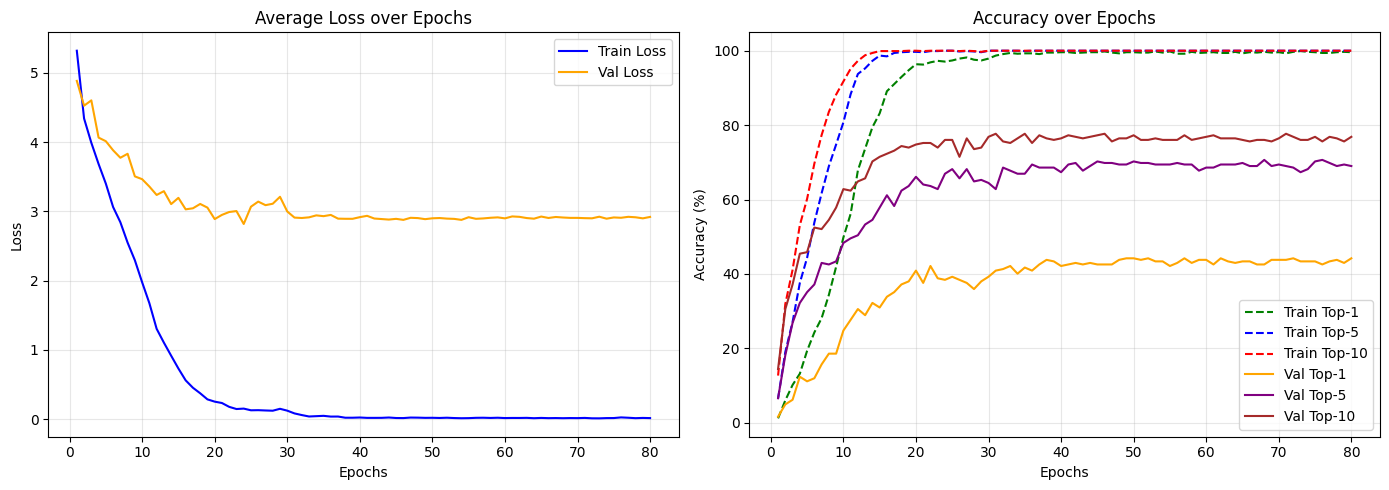

In [21]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='orange')
    plt.title('Average Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # accuracy (top 1, 5, 10)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_top1'], label='Train Top-1', color='green', linestyle='--')
    plt.plot(epochs, history['train_top5'], label='Train Top-5', color='blue', linestyle='--')
    plt.plot(epochs, history['train_top10'], label='Train Top-10', color='red', linestyle='--')
    plt.plot(epochs, history['val_top1'], label='Val Top-1', color='orange')
    plt.plot(epochs, history['val_top5'], label='Val Top-5', color='purple')
    plt.plot(epochs, history['val_top10'], label='Val Top-10', color='brown')
        
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Evaluation

Now, we can evaluate the trained CTR_GCN model on our test data.

In [27]:
model_path = 'wlasl100_ctrgcn_final.pth'
try:
    # load state dict
    state_dict = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [34]:
test_ds = WLASL100Dataset(dataset_root, 'test')
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

t1_correct = 0
t5_correct = 0
t10_correct = 0
total_samples = 0

print("Running evaluation on test data...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        
        c1, c5, c10 = get_topk_counts(outputs, labels, topk=(1, 5, 10))
        
        t1_correct += c1
        t5_correct += c5
        t10_correct += c10
        total_samples += labels.size(0)

print(f"Total Test Samples: {total_samples}")
print(f"Top-1 Accuracy:  {100 * t1_correct / total_samples:.2f}%")
print(f"Top-5 Accuracy:  {100 * t5_correct / total_samples:.2f}%")
print(f"Top-10 Accuracy: {100 * t10_correct / total_samples:.2f}%")

Running evaluation on test data...
Total Test Samples: 200
Top-1 Accuracy:  36.00%
Top-5 Accuracy:  67.00%
Top-10 Accuracy: 77.00%


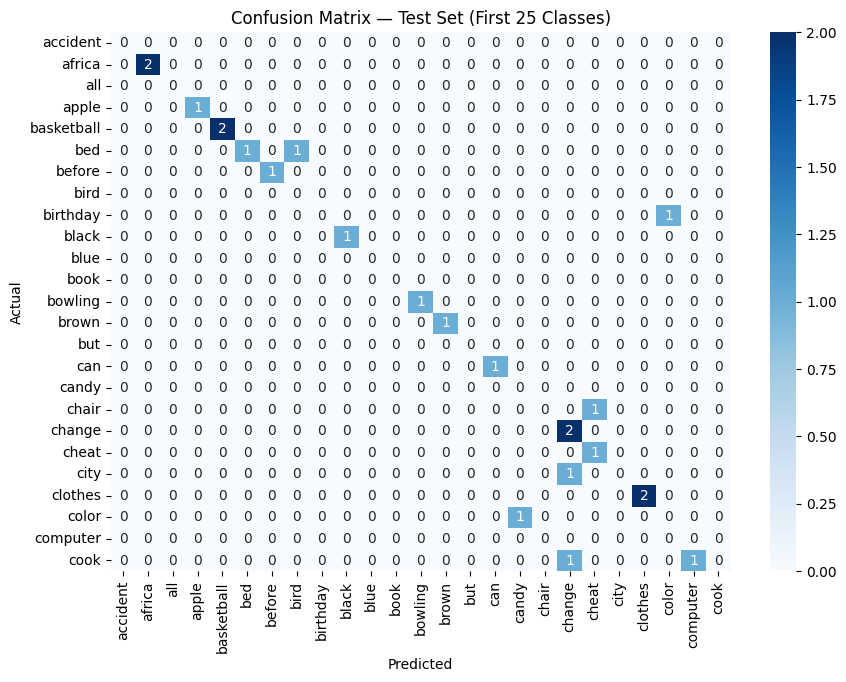

In [35]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

with open("wlasl100_label_map.json", "r") as f:
    label_map = json.load(f)
    idx_to_word = {v: k for k, v in label_map.items()}
    NUM_CLASSES = len(label_map)

def plot_confusion_matrix(y_true, y_pred, classes, limit=20):
    mask = (y_true < limit) & (y_pred < limit)
    y_true_sub = y_true[mask]
    y_pred_sub = y_pred[mask]

    class_names = [classes[i] for i in range(limit)]

    cm = confusion_matrix(y_true_sub, y_pred_sub, labels=range(limit))

    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix — Test Set (First {limit} Classes)')
    plt.show()

plot_confusion_matrix(np.array(all_labels), np.array(all_preds), idx_to_word, limit=25)


##